In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from src.read_deaths import read_deaths
from src.read_pop import read_pop

deaths = read_deaths()
pop = read_pop()  # TODO: Group 100+ population

plt.rcParams["figure.figsize"] = [22, 6]
plt.rcParams["axes.xmargin"] = 0.012


## Raw deaths per year

We start by looking at how many people died each year.

We can make two observations:

- Deaths are pretty stable from 1962 to 2019, with a few dips and peaks (e.g a 6.4% increase from 2014 to 2015)
- 2020 breaks this stability with a 9.2% increase from 2019 (TODO 2021). This could be explained by COVID-19.

We would like to explain why the deaths remain stable from 1962 to 2019 despite the major advances made in the health sector.


<BarContainer object of 59 artists>

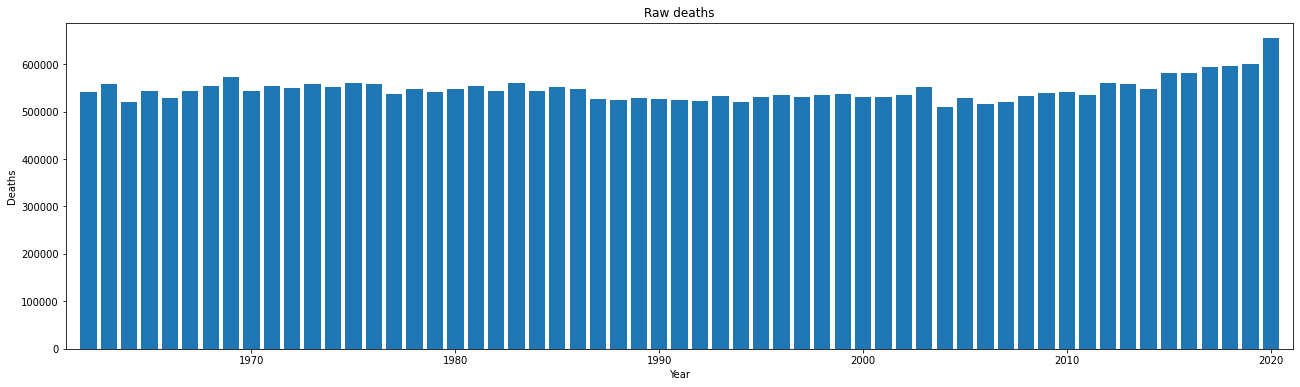

In [2]:
df = deaths[deaths["sex"] == "E"].groupby("year", as_index=0).agg(sum)

plt.figure()
plt.title("Raw deaths")
plt.xlabel("Year")
plt.ylabel("Deaths")
plt.bar(df["year"], df["deaths"])


## Taking population count into account

The first hypothesis is that the number of deaths does not decrease because the population is growing each year.  
To verify it, we graph the death rate per year (deaths / pop), and we do see a downward trend indeed.


<BarContainer object of 59 artists>

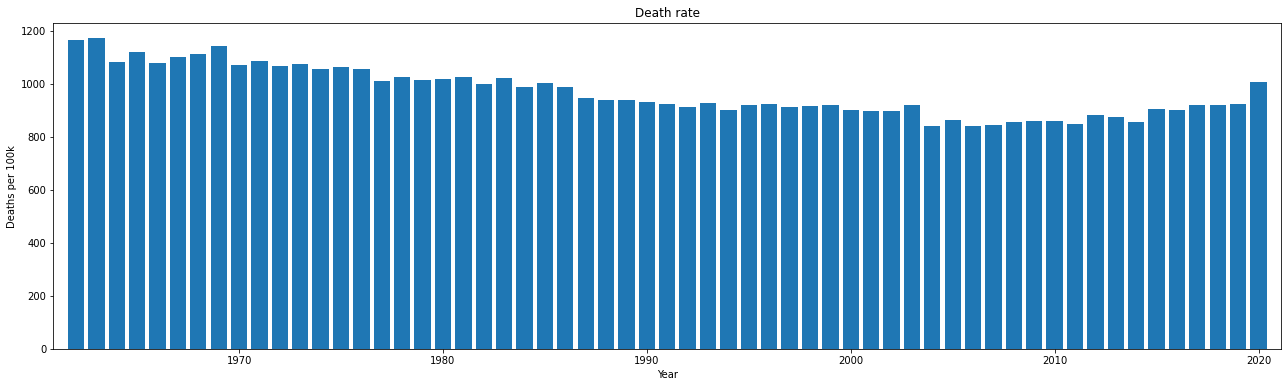

In [3]:
df = pd.merge(pop, deaths, on=["year", "sex", "age"]).groupby(
    "year", as_index=0).agg(sum)

plt.figure()
plt.title("Death rate")
plt.xlabel("Year")
plt.ylabel("Deaths per 100k")
plt.bar(df["year"], 100_000 * df["deaths"] / df["pop"])


## Taking age into account

We would like to analyze the death rate for each age.  
Let's take 2000 and 2019 as examples: we see in the graph below that **the death rate in 2000 is strictly higher than the death rate in 2019 for any age** except 85 and 99.  
This is surprising as in the graph above, the death rate in 2019 is 2.5% higher than in 2000.


Ages for which the death rate is higher in 2019 than in 2000: [85, 99]


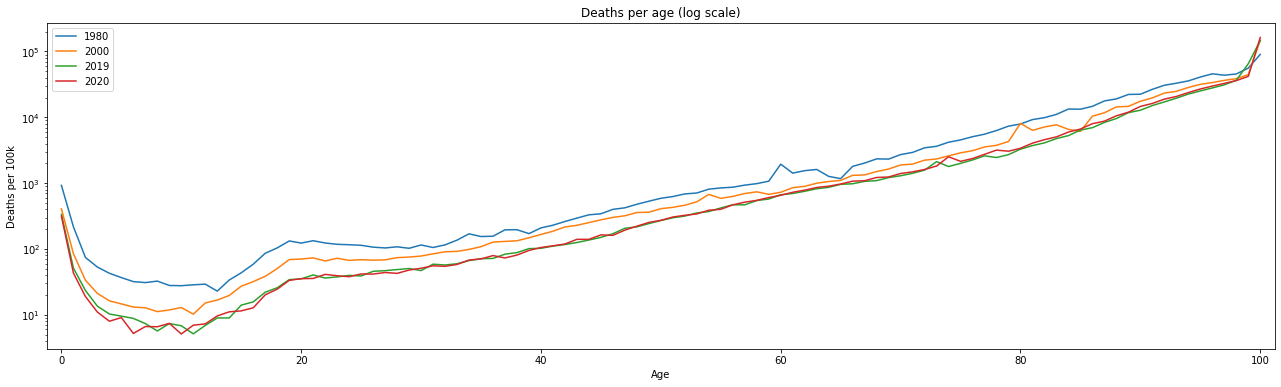

In [4]:
df = pd.merge(pop, deaths, on=["year", "sex", "age"]).groupby(
    ["year", "age"], as_index=0).agg(sum)


plt.figure()
plt.title("Deaths per age (log scale)")
plt.xlabel("Age")
plt.ylabel("Deaths per 100k")
plt.yscale('log')
for year in [1980, 2000, 2019, 2020]:
    df_2 = df[df["year"] == year]
    plt.plot(df_2["age"], 100_000 * df_2["deaths"] / df_2["pop"],
             label=str(year))
plt.legend()

df = pd.merge(df[df["year"] == 2000], df[df["year"] == 2019], on="age")
print("Ages for which the death rate is higher in 2019 than in 2000:",
      [*df[df["deaths_x"] / df["pop_x"] <= df["deaths_y"] / df["pop_y"]]["age"]])


### The simpson paradox

The reason why the death rate is higher in 2000 than in 2019 **for any age**, but the death rate is higher in 2019 than in 2000 is because of the population aging, in particular due to the baby boom in 1946.  
We can see in the graphs below the huge spike in new borns, as well as the quick income of old people over the years.

The disconnection seen previously is thus explained by the Simpson paradox: _the mortality being higher in 2019 than in 2000 does not mean you'd have less chance of dying in 2000, but that you are more likely to randomly pick an old person (likely to die) in 2019 than in 2000_.


<BarContainer object of 98 artists>

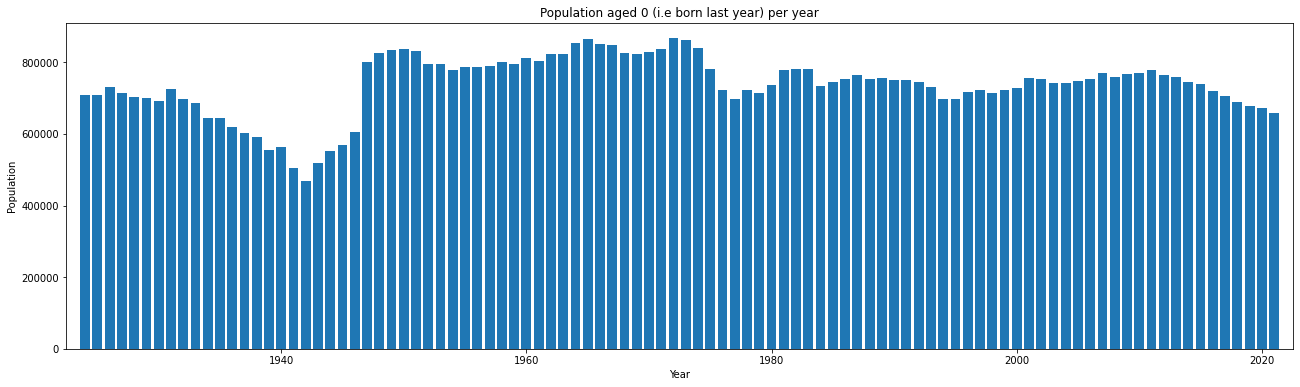

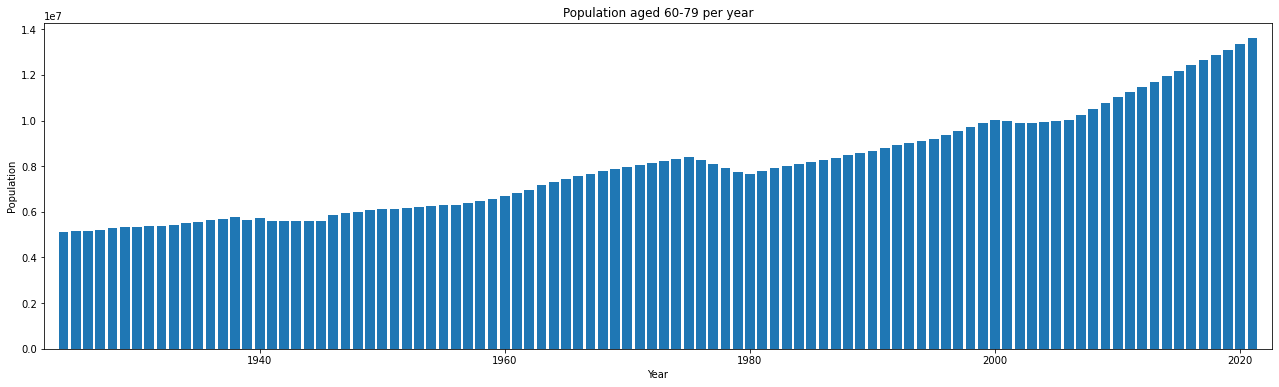

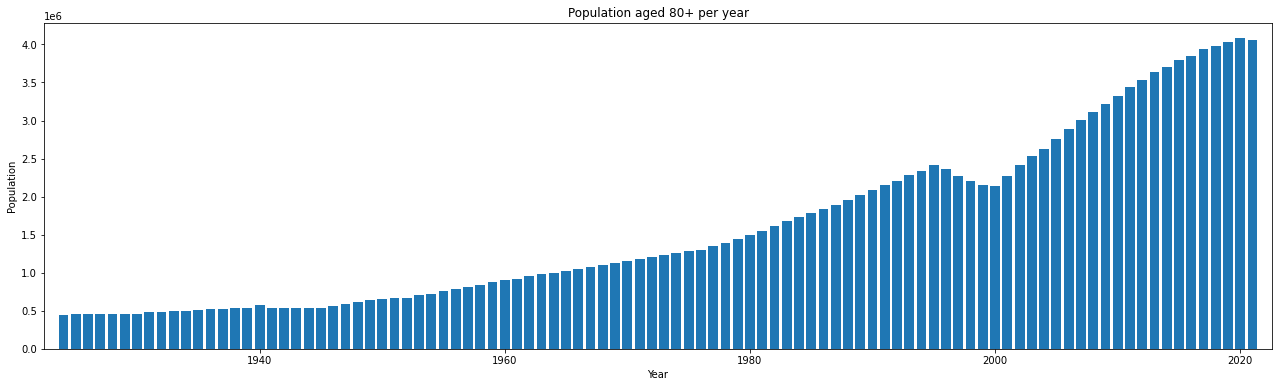

In [5]:
df_0 = pop[pop["age"] == 0]
df_0 = df_0.groupby(["year"], as_index=0).agg({"pop": sum})
df_0 = df_0.query("year >= 1924")

plt.figure()
plt.title("Population aged 0 (i.e born last year) per year")
plt.xlabel("Year")
plt.ylabel("Population")
plt.bar(df_0["year"], df_0["pop"])


df_60_80 = pop[(pop["age"] >= 60) & (pop["age"] <= 79)]
df_60_80 = df_60_80.groupby(["year"], as_index=0).agg({"pop": sum})
df_60_80 = df_60_80.query("year >= 1924")

plt.figure()
plt.title("Population aged 60-79 per year")
plt.xlabel("Year")
plt.ylabel("Population")
plt.bar(df_60_80["year"], df_60_80["pop"])


df_80_pl = pop[(pop["age"] >= 80)]
df_80_pl = df_80_pl.groupby(["year"], as_index=0).agg({"pop": sum})
df_80_pl = df_80_pl.query("year >= 1924")

plt.figure()
plt.title("Population aged 80+ per year")
plt.xlabel("Year")
plt.ylabel("Population")
plt.bar(df_80_pl["year"], df_80_pl["pop"])


## Age standardized death rate

This graph reflects the intuitive decrease in chance of deaths.


<BarContainer object of 59 artists>

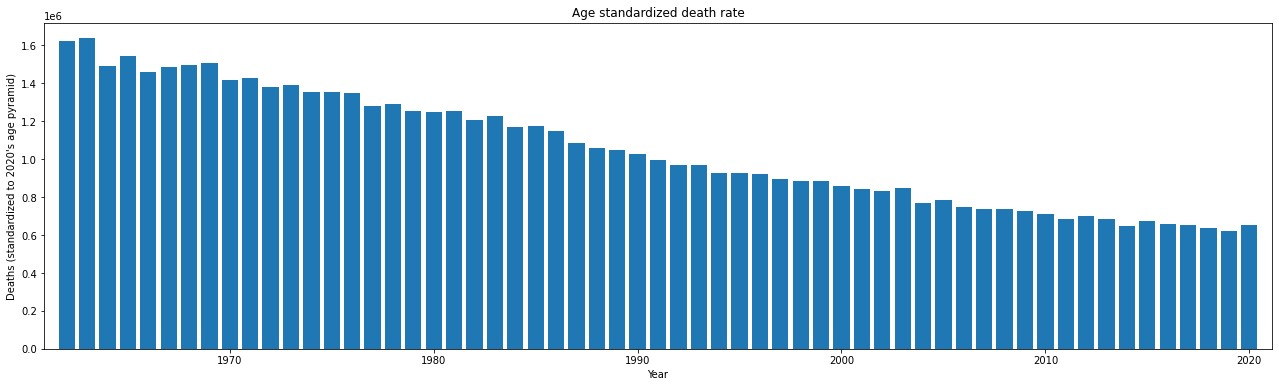

In [6]:
ref_year = 2020

ref_df = pop[pop["year"] == ref_year]
ref_total_pop = int(ref_df.agg({"pop": sum}))
df = pd.merge(pop, deaths, on=["year", "sex", "age"])
df = pd.merge(df, ref_df, on=["sex", "age"], suffixes=("", "_ref"))
df["asmr"] = df["pop_ref"] * df["deaths"] / df["pop"]
df = df.groupby(["year"], as_index=0).agg(sum)

plt.figure()
plt.title("Age standardized death rate")
plt.xlabel("Year")
plt.ylabel("Deaths (standardized to 2020's age pyramid)")
plt.bar(df["year"], df["asmr"])
